# Weights are subjective and often need adjustment
There are tools in `pyemu` to assist with weight adjustment to balance the contribution of various groups.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pyemu
import os, shutil
import sys
sys.path.append('..')

### Copy down the base  files for the freyberg model with K and R parameters

In [2]:
import freyberg_setup
freyberg_setup.setup_pest_kr()
working_dir = freyberg_setup.WORKING_DIR_KR
pst_name = freyberg_setup.PST_NAME_KR


['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_kr
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_reweighting/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SU

### We can read in the base PST file and do a quick run


In [7]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [8]:
pst.control_data.noptmax

8

In [9]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)


run():pestpp freyberg_kr.pst


In [10]:
pst.phi

820.9711457028571

In [11]:
pst.phi_components

{'calflux': 0.0,
 'calhead': 820.9711457028571,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [12]:
pst.phi_components_normalized

{'calflux': 0.0,
 'calhead': 1.0,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

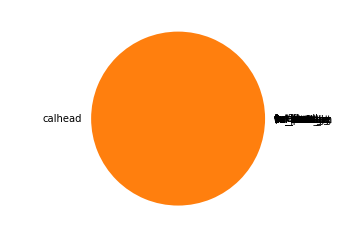

In [13]:
starting_components = pst.phi_components_normalized
plt.axis('equal')
plt.pie([float(v) for v in starting_components.values()], labels=[k for k in starting_components.keys()]);

In [26]:
pst.obs_groups

['flx_river_l',
 'vol_storage',
 'head',
 'calflux',
 'flx_total',
 'foretrav',
 'pothead',
 'vol_recharg',
 'vol_in-out',
 'flx_percent',
 'vol_percent',
 'calhead',
 'flx_in-out',
 'flx_recharg',
 'flx_wells',
 'flx_storage',
 'forehead',
 'foreflux',
 'flx_constan',
 'vol_river_l',
 'vol_total',
 'vol_wells',
 'vol_constan']

In [28]:
groups = ['calflux','calhead']

In [29]:
new_portions = [0.4,0.6]

In [30]:
sum(new_portions)

1.0

In [31]:
newcomponents = dict(zip(groups,[i*inpst.phi for i in new_portions]))

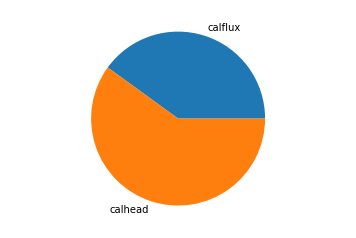

In [32]:
plt.axis('equal')
plt.pie([float(v) for v in newcomponents.values()], labels=[k for k in newcomponents.keys()]);

In [33]:
newcomponents

{'calflux': 328.3884582811429, 'calhead': 492.58268742171424}

In [40]:
pst.observation_data.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme
obsnme,,,,
flx_river_l_19700102,flx_river_l_19700102,-3706.027000,0.149770,calflux
cr03c10_19700102,cr03c10_19700102,22.331451,3.872983,calhead
cr03c16_19700102,cr03c16_19700102,18.526869,3.872983,calhead
cr04c09_19700102,cr04c09_19700102,24.412637,3.872983,calhead
cr10c02_19700102,cr10c02_19700102,27.985834,3.872983,calhead
cr14c11_19700102,cr14c11_19700102,21.070509,3.872983,calhead
cr16c17_19700102,cr16c17_19700102,15.468176,3.872983,calhead
cr22c11_19700102,cr22c11_19700102,20.485881,3.872983,calhead
cr23c16_19700102,cr23c16_19700102,15.308345,3.872983,calhead


In [35]:
pst.phi_components

{'calflux': 0.0,
 'calhead': 820.9711457028571,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [36]:
pst.adjust_weights_by_list('rivflux_cal',1.0)
pst.phi_components

{'calflux': 0.0,
 'calhead': 820.9711457028571,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [37]:
pst.adjust_weights(obsgrp_dict=newcomponents)
pst.phi_components

{'calflux': 328.388458281143,
 'calhead': 492.5826874217143,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [39]:
pst.observation_data.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme
obsnme,,,,
flx_river_l_19700102,flx_river_l_19700102,-3706.027000,0.149770,calflux
cr03c10_19700102,cr03c10_19700102,22.331451,3.872983,calhead
cr03c16_19700102,cr03c16_19700102,18.526869,3.872983,calhead
cr04c09_19700102,cr04c09_19700102,24.412637,3.872983,calhead
cr10c02_19700102,cr10c02_19700102,27.985834,3.872983,calhead
cr14c11_19700102,cr14c11_19700102,21.070509,3.872983,calhead
cr16c17_19700102,cr16c17_19700102,15.468176,3.872983,calhead
cr22c11_19700102,cr22c11_19700102,20.485881,3.872983,calhead
cr23c16_19700102,cr23c16_19700102,15.308345,3.872983,calhead


In [41]:
pst.phi

820.9711457028573

In [47]:
pst.write(os.path.join(working_dir,pst_name.replace(".pst","_rewght.pst")))
pyemu.helpers.run("pestpp {0}".format(pst_name.replace(".pst","_rewght.pst")),cwd=working_dir)

run():pestpp freyberg_kr_rewght.pst


## Relating weights to observation noise

Weights can initially be thought of as the reciprocal of observation noise, as characterized by standard deviation of the observation: 
$w=\frac{1}{\sigma}$

After adjustment, it's a good idea to calculate the equivalent $\sigma$ for each observation to determine whether it remains realistic. In this case:

In [44]:
#initial weight for head
w=1
sig=1/w
sig

1.0

In [45]:
#new weight for head
w=.774597
sig=1/w
sig

1.2909938974718467

## This also applied after calibration, before uncertainty calculations...

According to the discrepancy prinicipal, the final objective function should equal the number of non-zero weighted observations....this is rarely the case.  This means we couldn't fit the data as well as we thought we could, which is usually a result of model error (not measurement error).  While this is an advanced topic, one really cheap way to cope with this problem is to scale the observation weights by the final residuals so that they reflect how well we actual could fit. 

In [50]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name.replace(".pst","_rewght.pst")))
pst.phi

779.2592665906188

In [52]:
pst.res.loc[pst.nnz_obs_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
flx_river_l_19700102,flx_river_l_19700102,calflux,-3706.027000,-3814.782715,108.755715,0.149770
cr03c10_19700102,cr03c10_19700102,calhead,22.331451,23.974606,-1.643154,3.872983
cr03c16_19700102,cr03c16_19700102,calhead,18.526869,19.917816,-1.390947,3.872983
cr04c09_19700102,cr04c09_19700102,calhead,24.412637,24.770731,-0.358094,3.872983
cr10c02_19700102,cr10c02_19700102,calhead,27.985834,30.251448,-2.265613,3.872983
cr14c11_19700102,cr14c11_19700102,calhead,21.070509,18.847574,2.222934,3.872983
cr16c17_19700102,cr16c17_19700102,calhead,15.468176,17.488869,-2.020692,3.872983
cr22c11_19700102,cr22c11_19700102,calhead,20.485881,17.894899,2.590982,3.872983
cr23c16_19700102,cr23c16_19700102,calhead,15.308345,15.635373,-0.327028,3.872983


In [53]:
pst.adjust_weights_resfile()
pst.phi

14.000000000000002

In [54]:
pst.observation_data.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme
obsnme,,,,
flx_river_l_19700102,flx_river_l_19700102,-3706.027000,0.009195,calflux
cr03c10_19700102,cr03c10_19700102,22.331451,0.615967,calhead
cr03c16_19700102,cr03c16_19700102,18.526869,0.615967,calhead
cr04c09_19700102,cr04c09_19700102,24.412637,0.615967,calhead
cr10c02_19700102,cr10c02_19700102,27.985834,0.615967,calhead
cr14c11_19700102,cr14c11_19700102,21.070509,0.615967,calhead
cr16c17_19700102,cr16c17_19700102,15.468176,0.615967,calhead
cr22c11_19700102,cr22c11_19700102,20.485881,0.615967,calhead
cr23c16_19700102,cr23c16_19700102,15.308345,0.615967,calhead


See how much the weights were decreased?  This has implications for FOSM and Monte Carlo sampling...``pestpp`` does this rescaling automatically when it calculates FOSM uncertainty measures.  Its listed in the .rec file - check it out!